# Predicting Whether Clients Will Subscribe To A Term Deposit Based On Their Information. 
---

<br> Authors: Godsgift Braimah, Devon Vorster, Chikire Aku-Ibe, & Fu Hung Kwong <br>

In [26]:
import pandas as pd
import numpy as np
import altair_ally as aly
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform, randint, uniform
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandera as pa
aly.alt.data_transformers.enable('vegafusion')


DataTransformerRegistry.enable('vegafusion')

# Summary:
---
We built a classification model using both the Logistic Regression and Support Vector Classifier (SVC) which can use the information related to the client and the marketing contact to predict whether a client will subscribe to a term deposit.

Our final classifier, the Logistic Regression model, performed well on an unseen test data set, achieving a Test Score (Accuracy) of **0.90375** (compared to **0.90125** for SVC). The Train Score was 0.905625, indicating a good fit without significant overfitting. Although the simple accuracy score does not detail the balance of True Positives versus False Negatives, an accuracy exceeding **90%** suggests the model is highly effective.

Given our goal is to increase the subscription rate, the model's primary goal is to minimize the False Negative rate, avoiding the error of predicting a client will not subscribe when they would have. The current performance suggests that using this model for initial client prioritization could significantly improve resource allocation, making the model valuable for immediate business implementation. However, further analysis of precision and recall would be necessary to optimize its practical utility.

# Introduction:
---
Direct marketing campaigns, particularly those relying on phone calls, are a significant investment for banking institutions. The success of these campaigns is measured by the client subscription rate to a product like a term deposit. Another dataset shows that the subscription rate of term deposit in a Portuguese banking is only around 11.70% [Ngu Hui En 2024](https://medium.com/@nguhe/predictive-analysis-of-client-subscription-rates-in-the-portuguese-banking-sector-using-sas-40fb04a9dcd3), optimizing the targeting strategy is crucial to maximize return on investment and minimize operational costs.

Here we ask if a machine learning algorithm can be used to predict whether a client will subscribe to a term deposit based on information related to the client, such as type of job, education level; and also the marketing contact, e.g. number of contacts during the campaign, number of days since last contact. Answering this question is important because term deposit campaigns often require multiple contacts to the same client, making the process labor-intensive and expensive. Thus, if a machine learning algorithm can accurately and effectively predict client subscription, this could allow the bank to prioritize clients who are most likely to convert, leading to more efficient resource allocation and a higher overall subscription rate, improving the campaign results.

# Methods:
---

## Data: 
The data we used was obtained the UCI Machine Learning Repository which can be found [here](https://doi.org/10.24432/C5K306), specifically the Bank Marketing dataset of a Portuguese bank institution . The dataset contains various features about bank customers and whether they subscribed to a term deposit, an investment product offered by the bank (variable y). Each row in the dataset contains details of customers which was used to predict if they would subscribe to the term deposit or not. The original dataset contains 45211 records with 16 features and one target (17 columns). For the purpose of this analysis, we sampled 4,000 records from the original dataset to speed up the EDA and model training process.


## Analysis: 
We started this analysis by perfoming an exploratory data analysis (EDA) to understand the nature of the variables and their relationships. We observed some missing values in the dataset. We also observed that the target variable (y) was imbalanced with a higher proportion of customers not subscribing to the term deposit. 

Furthermore, distribution plots for variables previous, pday, campaign, duration, balance were highly right-skewed. This implies that most customers had low values for these varaibles and a few customers had high values. In addition, the correlation plots in Figure 3 showed that "previous" and "pday" had the highest positive correlation.

We decided to use both Logistic Regression and Support Vector Classifier (SVC) models for this analysis.The [sklearn](https://scikit-learn.org/stable/) package was greatly used in these processes. We performed hyperparameter tuning using Python RandomizedSearchCV to find the best parameters for each model. We mapped the values of the target y, using 'yes': 1, 'no': 0. The data was split using 80% for the training set and 20% for the test set. In the preprocessing, we dropped 'day_of_week' and 'pdays' because we considered them not relevant for analysis. The 'poutcome' variable was also dropped since it had a high number of missing values. Categorical variables were one-hot encoded, ordinal data were handled using ordinal encoding, numerical variables were scaled using StandardScaler and missing values for the selected features were imputed using SimpleImputer with the "most frequent" strategy.

The models were evaluated based on their accuracy on the test set. 


### Loading The Data

In [27]:
## Download Data 

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# metadata 
print(bank_marketing.metadata) 
  
# variable information 
print(bank_marketing.variables) 

# create complete dataset
bank_marketing_data =X; bank_marketing_data['y'] = y
#bank_marketing_data.to_csv('data/bank_marketing.csv')

# take a sample from teh data set
bank_marketing_sample = bank_marketing_data.sample(4000, random_state=522)
#bank_marketing_sample.to_csv('data/bank_marketing_small.csv')

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [50]:
# validate data

def assert_csv_format(file_path):
    assert file_path.endswith(".csv"), "Error: File must be a CSV."
    return True

schema = pa.DataFrameSchema(
    {
        "age": pa.Column(int, pa.Check.between(18, 91), nullable=True),
        "job": pa.Column(object, pa.Check.isin(['technician', 'blue-collar', 'admin.', 'entrepreneur',
       'management', 'self-employed', 'retired', 'services', 'unemployed',
       'housemaid', 'student']), nullable=True),
        "marital": pa.Column(object, pa.Check.isin(['married', 'single', 'divorced']), nullable=True),
        "education": pa.Column(object, pa.Check.isin(['tertiary', 'secondary', 'primary']), nullable=True), 
        "default": pa.Column(object, pa.Check.isin(['no', 'yes']), nullable=True),
        "balance": pa.Column(int, pa.Check.between(-10000000, 10000000), nullable=True),
        "housing": pa.Column(object, pa.Check.isin(['yes', 'no']), nullable=True),
        "loan": pa.Column(object, pa.Check.isin(['no', 'yes']), nullable=True),
        "contact": pa.Column(object, pa.Check.isin(['cellular', 'telephone']), nullable=True),
        "day_of_week": pa.Column(int, pa.Check.between(1, 31), nullable=True),
        "month": pa.Column(object, pa.Check.isin(['feb', 'nov', 'jul', 'may', 'aug', 'jun', 'apr', 'mar', 'jan',
       'oct', 'sep', 'dec']), nullable=True),
        "duration": pa.Column(int, pa.Check.between(0, 4000), nullable=True),
        "campaign": pa.Column(int, pa.Check.between(0, 40), nullable=True),
        "pdays": pa.Column(int, pa.Check.between(-1, 800), nullable=True), 
        "previous": pa.Column(int, pa.Check.between(0, 30), nullable=True),
        "poutcome": pa.Column(object, pa.Check.isin(['failure', 'success', 'other']), nullable=True),
        "y": pa.Column(object, pa.Check.isin(['no', 'yes']), nullable=True),
    },
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found."),
        pa.Check(lambda df: (df.isna().mean() < 0.10).any(), error="Missing values is above threshold.")
    ]
)
assert_csv_format("data/data_marketing_sample.csv")
schema.validate(bank_marketing_sample, lazy=True)


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
30577,42,technician,married,tertiary,no,1397,yes,no,cellular,6,feb,135,7,-1,0,NaN,no
30048,51,blue-collar,married,secondary,no,362,yes,yes,cellular,4,feb,318,3,-1,0,NaN,no
24147,23,admin.,single,secondary,no,40,no,no,telephone,10,nov,1239,1,-1,0,NaN,no
25584,57,entrepreneur,married,tertiary,no,1828,yes,no,cellular,19,nov,68,1,-1,0,NaN,no
15822,47,management,divorced,tertiary,no,2105,no,yes,cellular,21,jul,363,1,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15271,41,management,single,tertiary,no,0,yes,no,cellular,17,jul,509,7,-1,0,NaN,no
22396,31,management,single,tertiary,no,10215,no,no,cellular,22,aug,139,2,-1,0,NaN,no
21330,60,self-employed,married,tertiary,no,3,no,no,cellular,18,aug,80,2,-1,0,NaN,no
36012,43,self-employed,married,tertiary,yes,310,yes,no,cellular,11,may,84,7,-1,0,NaN,no


### EDA

In [ ]:
bank_marketing.data.features.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no
5,35,management,married,tertiary,no,231,yes,no,NaN,5,may,139,1,-1,0,NaN,no
6,28,management,single,tertiary,no,447,yes,yes,NaN,5,may,217,1,-1,0,NaN,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,NaN,5,may,380,1,-1,0,NaN,no
8,58,retired,married,primary,no,121,yes,no,NaN,5,may,50,1,-1,0,NaN,no
9,43,technician,single,secondary,no,593,yes,no,NaN,5,may,55,1,-1,0,NaN,no


In [ ]:
bank_marketing.data.targets.head(10)

,y
0,no
1,no
2,no
3,no
4,no
5,no
6,no
7,no
8,no
9,no


In [ ]:
bank_marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
bank_marketing_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 30577 to 9839
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          4000 non-null   int64 
 1   job          3969 non-null   object
 2   marital      4000 non-null   object
 3   education    3852 non-null   object
 4   default      4000 non-null   object
 5   balance      4000 non-null   int64 
 6   housing      4000 non-null   object
 7   loan         4000 non-null   object
 8   contact      2816 non-null   object
 9   day_of_week  4000 non-null   int64 
 10  month        4000 non-null   object
 11  duration     4000 non-null   int64 
 12  campaign     4000 non-null   int64 
 13  pdays        4000 non-null   int64 
 14  previous     4000 non-null   int64 
 15  poutcome     659 non-null    object
 16  y            4000 non-null   object
dtypes: int64(7), object(10)
memory usage: 562.5+ KB


In [ ]:

numeric_plot = aly.dist(bank_marketing_sample, color='y')

numeric_plot.properties(
    title="Figure 1: Univariate distributions of numeric variables in Bank Marketing Dataset"
)

alt.ConcatChart(...)

In [ ]:
# univariate distrbutions (counts) for the categorical variables

categorical_plots = aly.dist(
    bank_marketing_sample, dtype='object', color='y')

categorical_plots.properties(
    title="Figure 2: Univariate distributions of category variables in Bank Marketing Dataset"
)


alt.ConcatChart(...)

In [ ]:
correlation_plots = aly.corr(bank_marketing_sample)
correlation_plots.properties(
    title="Figure 3: Correlation Plots For Numeric variables in Bank Marketing Dataset"
)


alt.ConcatChart(...)

### Model Building and Evaluation

In [ ]:
bank_marketing_sample.isnull().sum() / bank_marketing_sample.shape[0] * 100

age             0.000
job             0.775
marital         0.000
education       3.700
default         0.000
balance         0.000
housing         0.000
loan            0.000
contact        29.600
day_of_week     0.000
month           0.000
duration        0.000
campaign        0.000
pdays           0.000
previous        0.000
poutcome       83.525
y               0.000
dtype: float64

In [ ]:
# preprocessing
#bank_marketing_sample = bank_marketing_sample.copy()

# map the target variable to numeric
bank_marketing_sample['y'] = bank_marketing_sample['y'].map({'yes': 1, 'no': 0})


# feature engineering on 'pdays' column into categorical determining if client was contacted before or not
bank_marketing_sample['pdays_contacted'] = bank_marketing_sample['pdays'].apply(lambda x: 'never' if x == -1 else 'contacted')

# dropping columns
bank_marketing_sample= bank_marketing_sample.drop(columns=['day_of_week', 'pdays', 'poutcome'])


# split data
X_train, X_test, y_train, y_test = train_test_split(bank_marketing_sample.drop(columns='y'), bank_marketing_sample['y'], test_size=0.2, random_state=522)

In [ ]:
#df.select_dtypes(include=['object']).nunique()

bank_marketing_sample.select_dtypes(include=['number']).columns

Index(['age', 'balance', 'duration', 'campaign', 'previous', 'y'], dtype='object')

In [ ]:
bank_marketing_sample.select_dtypes(include=['object']).columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'pdays_contacted'],
      dtype='object')

In [ ]:
bank_marketing_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 30577 to 9839
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              4000 non-null   int64 
 1   job              3969 non-null   object
 2   marital          4000 non-null   object
 3   education        3852 non-null   object
 4   default          4000 non-null   object
 5   balance          4000 non-null   int64 
 6   housing          4000 non-null   object
 7   loan             4000 non-null   object
 8   contact          2816 non-null   object
 9   month            4000 non-null   object
 10  duration         4000 non-null   int64 
 11  campaign         4000 non-null   int64 
 12  previous         4000 non-null   int64 
 13  y                4000 non-null   int64 
 14  pdays_contacted  4000 non-null   object
dtypes: int64(6), object(9)
memory usage: 500.0+ KB


In [ ]:
# separating columns by type of transformation required

# One-hot encoding
categorical_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact','month', 'pdays_contacted']
# Ordinal encoding
ordinal_cols = ['education']
# Standard scaling
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'previous']



We decided to train both a Logistic Regression and Support Vector Classifier (SVC) to determine which was more efficient in predicting if a customer would subscribed to the banks offering of term investments. We performed hyperparameter tuning using RandomizedSearchCV to find the best parameters for each model. The models were evaluated based on their accuracy on the test set.

In [ ]:
# defining the preprocessor

data_preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), categorical_cols
    ), (
        make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['unknown', 'primary', 'secondary', 'tertiary']], dtype=object)), ordinal_cols
    ), (StandardScaler(), numerical_cols))

In [ ]:
# Logistic Regression cross-validation with RandomizedSearchCV 
lr_pipe = make_pipeline(data_preprocessor, LogisticRegression(random_state=42, max_iter=1000))
param_dist1 = {"logisticregression__C": loguniform(1e-4, 1e3)} 
random_lr = RandomizedSearchCV(lr_pipe, param_distributions=param_dist1,
                                n_iter=100, n_jobs=-1, return_train_score=True, random_state=522)

In [ ]:
# Fit model
random_lr.fit(X_train, y_train)
print(f'Train Score: {random_lr.score(X_train, y_train)}')
print(f'Test Score: {random_lr.score(X_test, y_test)}')

Train Score: 0.905625
Test Score: 0.90375


In [ ]:
# SVC cross-validation with RandomizedSearchCV 
svc_pipe = make_pipeline(data_preprocessor, SVC(random_state=42))
param_dist = { "svc__C": loguniform(1e-2, 1e3), "svc__gamma": loguniform(1e-2, 1e3)}
random_svc = RandomizedSearchCV(svc_pipe, param_distributions=param_dist,
                                n_iter=100, n_jobs=-1, return_train_score=True, random_state=522)


In [ ]:
# Fit model
random_svc.fit(X_train, y_train)
print(f'Train Score: {random_svc.score(X_train, y_train)}')
print(f'Test Score: {random_svc.score(X_test, y_test)}')

Train Score: 0.919375
Test Score: 0.90125


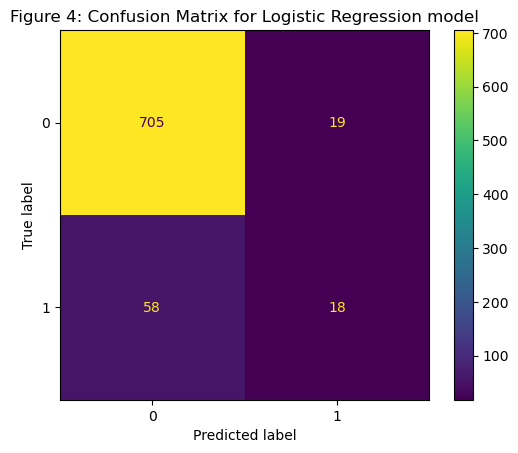

In [ ]:
#Confusion Matrix for Logistic Regression model
ConfusionMatrixDisplay.from_estimator(
    random_lr,
    X_test,
    y_test,
    values_format="d",
);
plt.title("Figure 4: Confusion Matrix for Logistic Regression model")
plt.show()

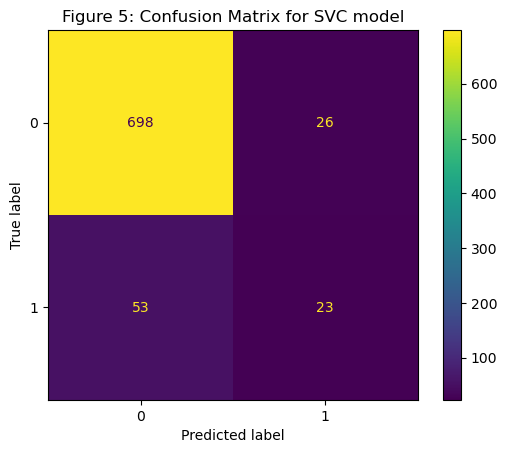

In [ ]:
#Confusion Matrix for SVC model

y = ConfusionMatrixDisplay.from_estimator(
    random_svc,
    X_test,
    y_test,
    values_format="d",
);
plt.title("Figure 5: Confusion Matrix for SVC model")
plt.show()


# Results & Discussion
---

Both our Logistic Regression and SVC classification models performed well on the testing data, with final scores of 0.90375 and 0.90125, respectively. Further comparison shows that the testing scores are similar to the training scores of 0.905625 and 0.919375, indicating that our models are well-fitted.

Considering the imbalance in our target class, accuracy alone is not sufficient for determining the suitability of our model. Therefore, exploring metrics from the confusion matrix and classification report is recommended as a next step.

A second area for further analysis is determining which specific features are most important for predicting whether a client will subscribe to a term deposit. Identifying these key features will enable the bank to better tailor its actions to increase subscription rates. In light of this, the Logistic Regression model is a better choice, as it provides more interpretable results. However, due to interactions between features and preprocessing steps such as regularization, the coefficients of the Logistic Regression model can become difficult to interpret. Nevertheless, if properly examined, the coefficient estimates can help identify the important characteristics the bank should focus on to increase its rate of subscriptions to term deposits.

# References:
---
<br> Ngu, H. E. (2024). Predictive analysis of client subscription rates in the Portuguese banking sector using SAS. Medium. https://medium.com/@nguhe/predictive-analysis-of-client-subscription-rates-in-the-portuguese-banking-sector-using-sas-40fb04a9dcd3 <br>
<br>Timbers, T. (n.d.). breast_cancer_predictor (Version 0.0.1) [Computer software]. GitHub. https://github.com/ttimbers/breast_cancer_predictor/tree/0.0.1<br>
<br>Moro, S., Rita, P., & Cortez, P. (2014). Bank Marketing [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306. <br>
<br>Scikit-learn. (n.d.). scikit-learn: Machine learning in Python. Retrieved November 21, 2025, from https://scikit-learn.org/stable/<br>
<br>uci-ml-repo (2025). ucimlrepo: Python package for dataset imports from the UCI Machine Learning Repository [Computer software]. GitHub. https://github.com/uci-ml-repo/ucimlrepo<br>